In [1]:
# Packages for neural networks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import datetime 
import import_ipynb
import histplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas
import seaborn
import IPython
import IPython.display

importing Jupyter notebook from histplot.ipynb


In [2]:
# Have the Data then convert them into hourly data. 
def hourly(weather):
    minute = 0
    Hourly = np.zeros((8760, 4))
    hour = 0
    endminute = 60
    while (minute < len(weather[:, 3]) and hour < 8760):
        temp = np.nanmean(weather[np.arange(minute, endminute), 0])
        relhum = np.nanmean(weather[np.arange(minute, endminute), 1])
        air_p = np.nanmean(weather[np.arange(minute, endminute), 2])
        precip = np.nansum(weather[np.arange(minute, endminute), 3])
        if (minute+60 < len(weather[:, 3])):
            minute += 60
        if (minute+60 < len(weather[:, 3])):
            endminute = minute + 60
        else:
            endminute = len(weather[:, 3])
        Hourly[hour, 0] = temp
        Hourly[hour, 1] = relhum
        Hourly[hour, 2] = air_p
        Hourly[hour, 3] = precip
        hour += 1
    
    return Hourly

In [3]:
# Upload data
ASC = '__ASC_ASCIIIn.mrk'
direct = 'C:/Users/tyron/Documents/Geoscience/weather/'

In [4]:
# Get Data for the completed years of 2018, 2019, and 2020
Whole18 = histplot.getData(18, direct, ASC, 1, 365, np.arange(3, 7), float)
Whole19 = histplot.getData(19, direct, ASC, 1, 365, np.arange(3, 7), float)
Whole20 = histplot.getData(20, direct, ASC, 1, 366, np.arange(3, 7), float)

In [5]:
hour18 = hourly(Whole18)
hour19 = hourly(Whole19)
hour20 = hourly(Whole20)


In [6]:
# Periodicity of Time 
day = 24*60*60 # Number in seconds
year = (365.2425)*day # Number in seconds



In [7]:
hour_all = np.concatenate([hour18, hour19, hour20], axis = 0)
hour_all.shape

(26280, 4)

In [8]:
len(hour_all)

26280

In [9]:
new_hour = pandas.DataFrame(hour_all)

In [10]:
new_hour = new_hour.rename({0: "Temperature ($^\circ C$)", 1 : "Relative Humidity (%)", 2: "Atmospheric Pressure (bar)", 3: "Precipitation (mm)"}, axis = 'columns')
new_hour

,Temperature ($^\circ C$),Relative Humidity (%),Atmospheric Pressure (bar),Precipitation (mm)
0,-10.955000,45.361667,1.017778,0.0
1,-11.401667,46.405000,1.017877,0.0
2,-11.616667,47.426667,1.018020,0.0
3,-11.930000,48.390000,1.018145,0.0
4,-12.368333,49.235000,1.018128,0.0
...,...,...,...,...
26275,5.088333,42.065000,1.016072,0.0
26276,5.028333,43.433333,1.015270,0.0
26277,4.566667,47.421667,1.014422,0.0
26278,4.046667,50.323333,1.013760,0.0


In [11]:
column_indices = {name: i for i, name in enumerate(new_hour.columns)}

n = len(new_hour)
train_df = new_hour[0:int(n*0.7)]
val_df = new_hour[int(n*0.7):int(n*0.9)]
test_df = new_hour[int(n*0.9):]

num_features = new_hour.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

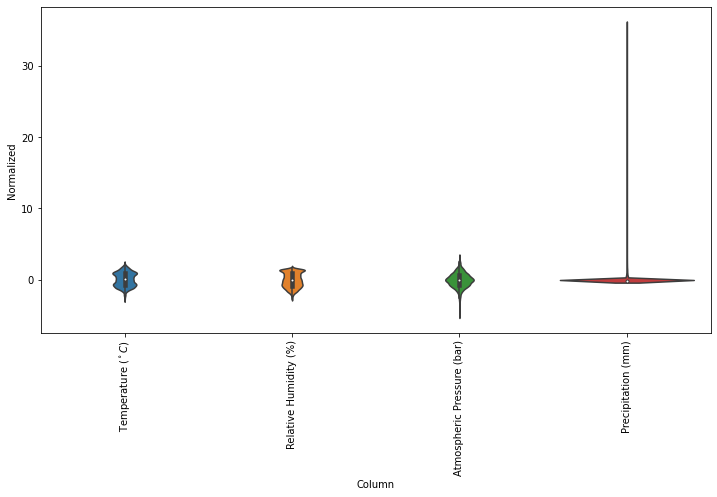

In [13]:
df_std = (new_hour - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = seaborn.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(new_hour.keys(), rotation=90)

In [14]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    
    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Temperature ($^\circ C$)'])
w1


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Temperature ($^\\circ C$)']

In [16]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Temperature ($^\circ C$)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Temperature ($^\\circ C$)']

In [17]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 4)
Inputs shape: (3, 6, 4)
labels shape: (3, 1, 1)


In [19]:
w2.example = example_inputs, example_labels

In [20]:
def plot(self, model=None, plot_col='Temperature ($^\circ C$)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
    plt.xlabel('Time [h]')
WindowGenerator.plot = plot

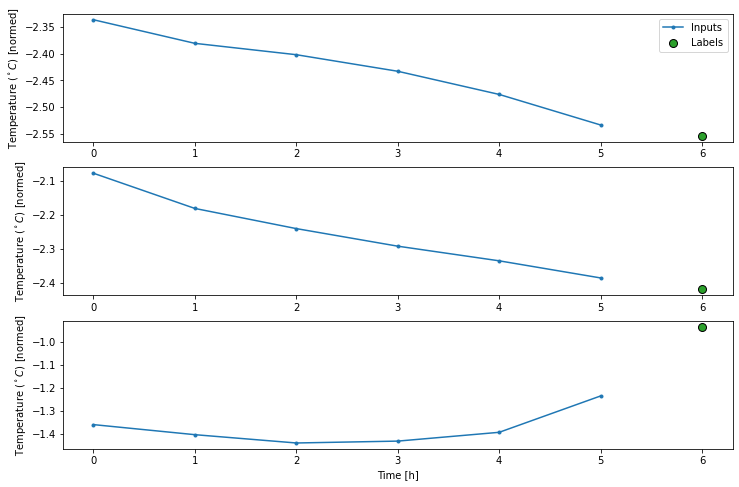

In [21]:
w2.plot()


In [22]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [23]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """ Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [24]:
# Each element is an (inputs, label) pair
w2.train.element_spec

Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Temperature ($^\\circ C$)']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Temperature ($^\\circ C$)']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(TensorSpec(shape=(None, 6, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [25]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 6, 4)
Labels shape (batch, time, features): (32, 1, 1)


In [26]:
# Single Step models - Predict a single features's value 
#timestep in the future based only on the current conditions
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Precipitation (mm)'])
single_step_window


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Precipitation (mm)']

In [27]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 4)
Labels shape (batch, time, features): (32, 1, 1)


In [28]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [29]:
baseline = Baseline(label_index=column_indices['Precipitation (mm)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
165/165 [==============================] - 0s 2ms/step - loss: 1.7560 - mean_absolute_error: 0.1707


In [30]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Precipitation (mm)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Precipitation (mm)']

In [31]:
baseline1 = Baseline(label_index=column_indices['Precipitation (mm)'])

baseline1.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline1.evaluate(wide_window.val)
performance['Baseline'] = baseline1.evaluate(wide_window.test, verbose=0)

164/164 [==============================] - 0s 2ms/step - loss: 1.7634 - mean_absolute_error: 0.1711A: 0s - loss: 1.6745 - mean_absolute_error: 0.17


In [32]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline1(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


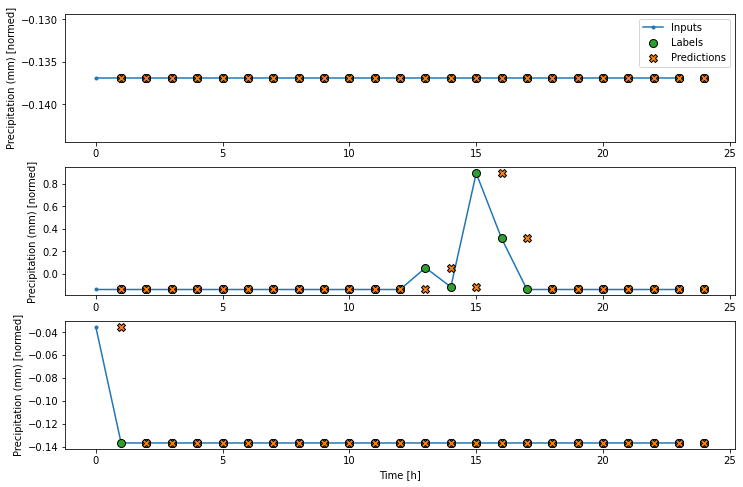

In [34]:
wide_window.plot(baseline1, plot_col = 'Precipitation (mm)')

In [35]:
#Linear Model 
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 1)
])

In [36]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 4)
Output shape: (32, 1, 1)


In [37]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [38]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
575/575 [==============================] - 1s 3ms/step - loss: 1.5866 - mean_absolute_error: 0.8139 - val_loss: 1.5182 - val_mean_absolute_error: 0.5671
Epoch 2/20
575/575 [==============================] - 1s 2ms/step - loss: 0.8991 - mean_absolute_error: 0.4294 - val_loss: 1.2349 - val_mean_absolute_error: 0.3114
Epoch 3/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7556 - mean_absolute_error: 0.2511 - val_loss: 1.1863 - val_mean_absolute_error: 0.2263
Epoch 4/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7330 - mean_absolute_error: 0.1964 - val_loss: 1.1829 - val_mean_absolute_error: 0.2148
Epoch 5/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7304 - mean_absolute_error: 0.1882 - val_loss: 1.1850 - val_mean_absolute_error: 0.2141
Epoch 6/20
165/165 [==============================] - 0s 2ms/step - loss: 1.1860 - mean_absolute_error: 0.2112


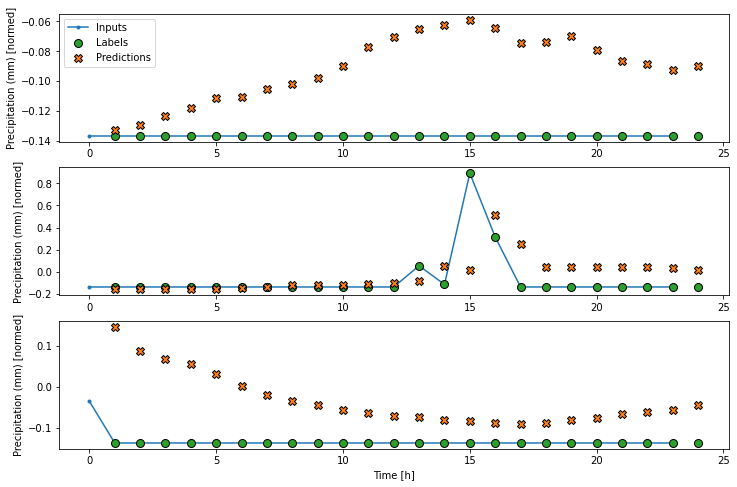

In [39]:
wide_window.plot(linear, plot_col = 'Precipitation (mm)')

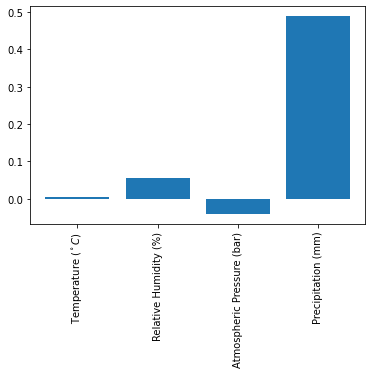

In [40]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [41]:
# Dense, stacks multiple Dense layers between input and output
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
575/575 [==============================] - 2s 3ms/step - loss: 0.7360 - mean_absolute_error: 0.1955 - val_loss: 1.3927 - val_mean_absolute_error: 0.2062
Epoch 2/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7349 - mean_absolute_error: 0.1836 - val_loss: 1.3235 - val_mean_absolute_error: 0.1897
Epoch 3/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7324 - mean_absolute_error: 0.1826 - val_loss: 1.2712 - val_mean_absolute_error: 0.2008
Epoch 4/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7213 - mean_absolute_error: 0.1797 - val_loss: 1.2815 - val_mean_absolute_error: 0.1881
Epoch 5/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7229 - mean_absolute_error: 0.1797 - val_loss: 1.2455 - val_mean_absolute_error: 0.1918
Epoch 6/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7199 - mean_absolute_error: 0.1816 - val_loss: 1.2631 - val_mean_absolute_error: 0.1930
Epoch 7/20
575/5

In [42]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Precipitation (mm)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Precipitation (mm)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

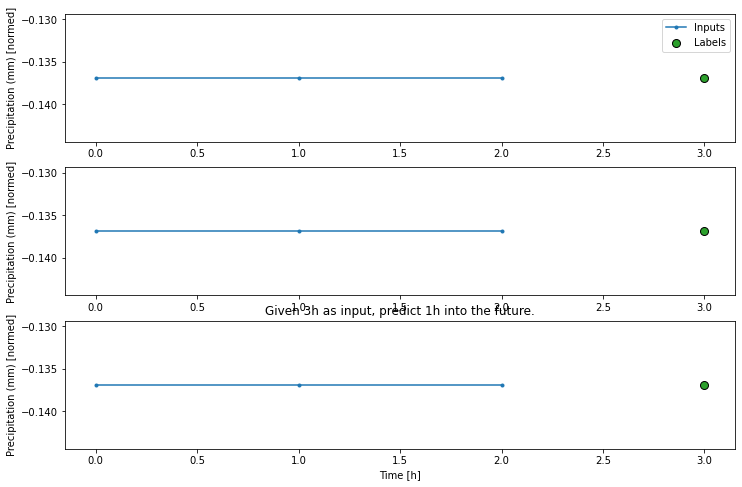

In [44]:
conv_window.plot(plot_col = 'Precipitation (mm)')
plt.title("Given 3h as input, predict 1h into the future.")

In [45]:
# Multi-step dense layers
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [46]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 4)
Output shape: (32, 1, 1)


In [47]:
history = compile_and_fit(multi_step_dense, conv_window)

#IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
575/575 [==============================] - 2s 3ms/step - loss: 0.7866 - mean_absolute_error: 0.2197 - val_loss: 1.1606 - val_mean_absolute_error: 0.1887
Epoch 2/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7346 - mean_absolute_error: 0.1964 - val_loss: 1.1542 - val_mean_absolute_error: 0.1751
Epoch 3/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7240 - mean_absolute_error: 0.1924 - val_loss: 1.1592 - val_mean_absolute_error: 0.1815
Epoch 4/20
575/575 [==============================] - 1s 2ms/step - loss: 0.7176 - mean_absolute_error: 0.1952 - val_loss: 1.1522 - val_mean_absolute_error: 0.1786
Epoch 5/20
575/575 [==============================] - 1s 3ms/step - loss: 0.7115 - mean_absolute_error: 0.1908 - val_loss: 1.1602 - val_mean_absolute_error: 0.1817
Epoch 6/20
165/165 [==============================] - 0s 2ms/step - loss: 1.1597 - mean_absolute_error: 0.1875


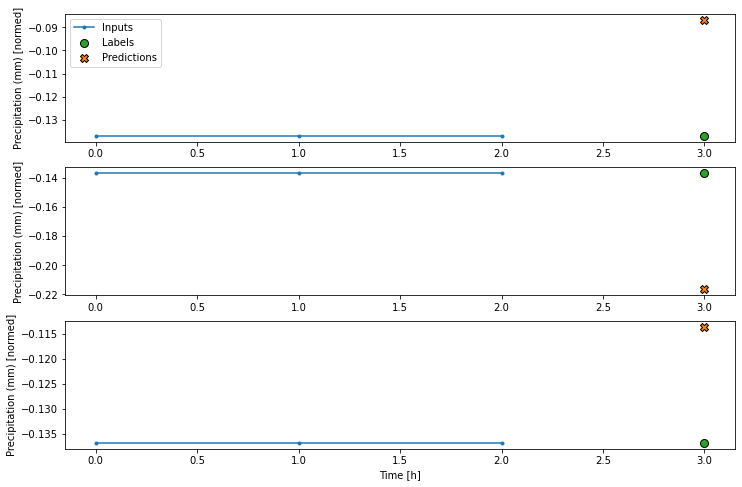

In [48]:
conv_window.plot(multi_step_dense, plot_col = 'Precipitation (mm)')


In [49]:
# Downside is that this approach is the resulting model can only be executed on input windows of exactly this shape! 


In [50]:
# Convolutional models can fix such a problem. Can also take in
# multiple time steps as inputs to each prediction. 
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [51]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 4)
Output shape: (32, 1, 1)


In [52]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

165/165 [==============================] - 0s 2ms/step - loss: 1.1593 - mean_absolute_error: 0.2145


In [53]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 4)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [54]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Precipitation (mm)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Precipitation (mm)']

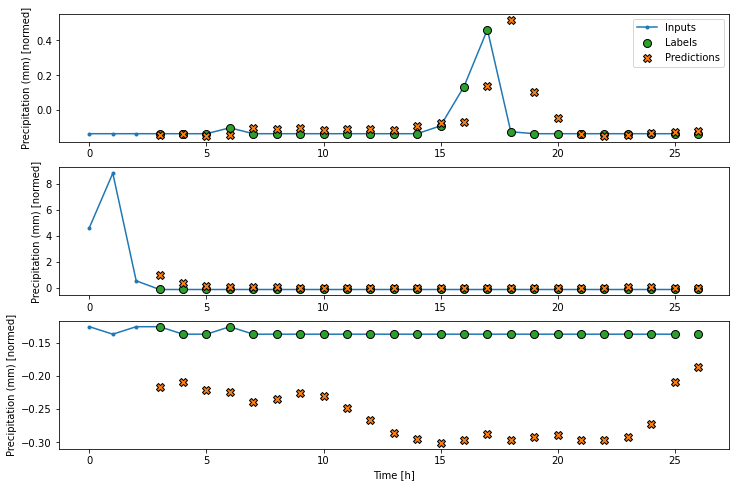

In [55]:
wide_conv_window.plot(conv_model,  plot_col ='Precipitation (mm)' )

In [56]:
# Recurrent neural network
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [57]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)
